In [167]:
import scanpy as sc
import pandas as pd
import palantir
import numpy as np
import matplotlib.pyplot as plt
import sys

In [168]:
# Add src to path for utilities
sys.path.append("../src")
try:
    import utils as src_utils
    assign_markers = src_utils.assign_markers
except (ImportError, AttributeError):
    # If import fails, define a simple placeholder
    def assign_markers(*args, **kwargs):
        pass

In [169]:
# Set up scanpy settings
sc.settings.verbosity = 1  # Verbosity level
sc.settings.set_figure_params(dpi=80, facecolor='white')
#set colormap as Spectral
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Spectral'


# Pseudotime Analysis: Tracing Cell Development Over Time

This notebook analyzes how cells change and develop over time using **pseudotime analysis**. 

Pseudotime is a computational method that orders cells along a continuous timeline based on their gene expression patterns, even when we only have snapshots of cells at different time points. 

## What We'll Do:
1. **Run two different pseudotime methods**:
    - **DPT (Diffusion Pseudotime)**: Uses diffusion maps to trace cell development
    - **Palantir**: A more sophisticated method that can handle multiple cell fates
2. **Compare the results** - See how well both methods agree on cell development timing

In [170]:
# Load data
adata_ax4 = sc.read(filename=f"../data/processed/AX4.h5ad")

In [171]:
# Make a copy to test
adata = adata_ax4.copy()

## Preparing the Data for Analysis

Before we can analyze pseudotime, we need to clean and prepare our data:

1. **Normalize**: Make sure all cells have similar total gene expression levels
2. **Log transform**: Reduce the impact of very highly expressed genes
3. **Find variable genes**: Identify genes that change the most between cells (these are most informative)
4. **Scale**: Standardize gene expression values
5. **Reduce dimensions**: Use PCA to focus on the most important patterns
6. **Build neighborhood graph**: Find which cells are similar to each other

In [172]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    batch_key='time',
)
adata = adata[:, adata.var.highly_variable].copy()

sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata)
sc.pp.neighbors(adata)

Let's first see what the actual time points are and the cell types.

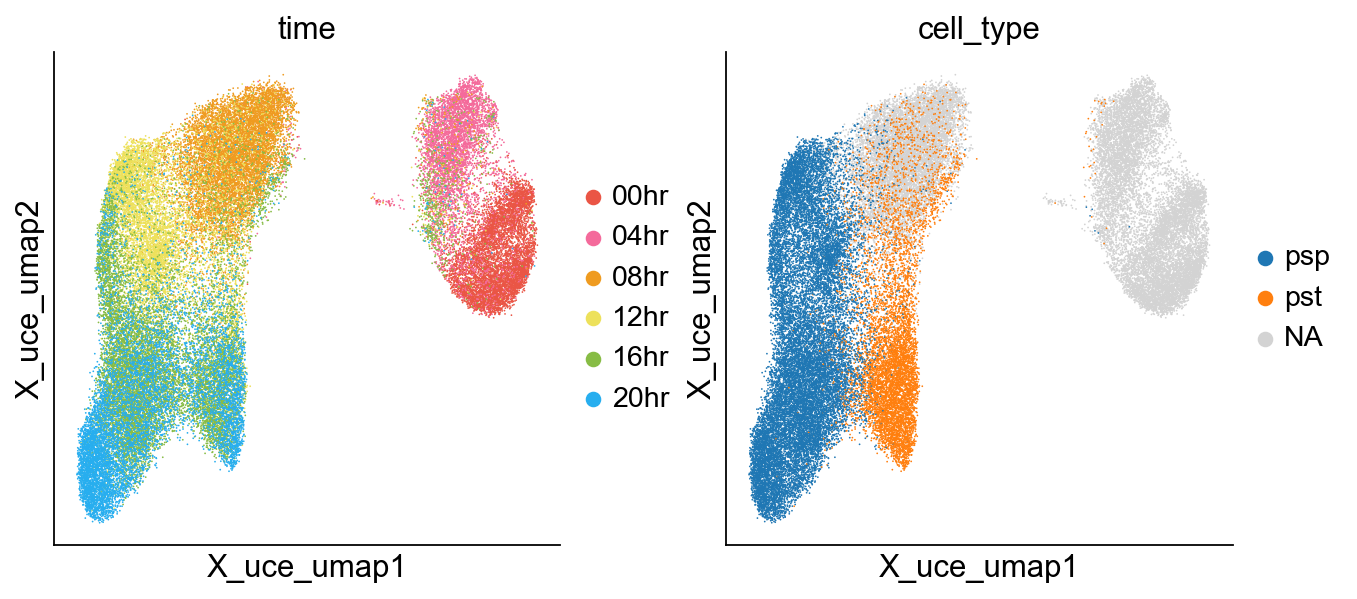

In [173]:
sc.pl.embedding(
    adata,
    basis="X_uce_umap",
    color=["time", "cell_type"],
)

In [174]:
terminal_states = pd.Series(
    ["prespore", "prestalk"],
    index=["CTGCATCGTAGACGGT-1", "TTAATCCTCCGTAATG-1"],
)
start_cell = "AGAGAATAGCTATCCA-1"
adata.uns['iroot'] = np.where(adata.obs_names == start_cell)[0][0]

For pseudotime analysis, we need to define:
- **Start cell**: Where development begins (a cell at the beginning of the experiment - 0hr)
- **Terminal states**: Where development ends (like differentiated cell types)

In our case:
- We start with an undifferentiated cell
- We end with two possible fates: **prespore** cells and **prestalk** cells

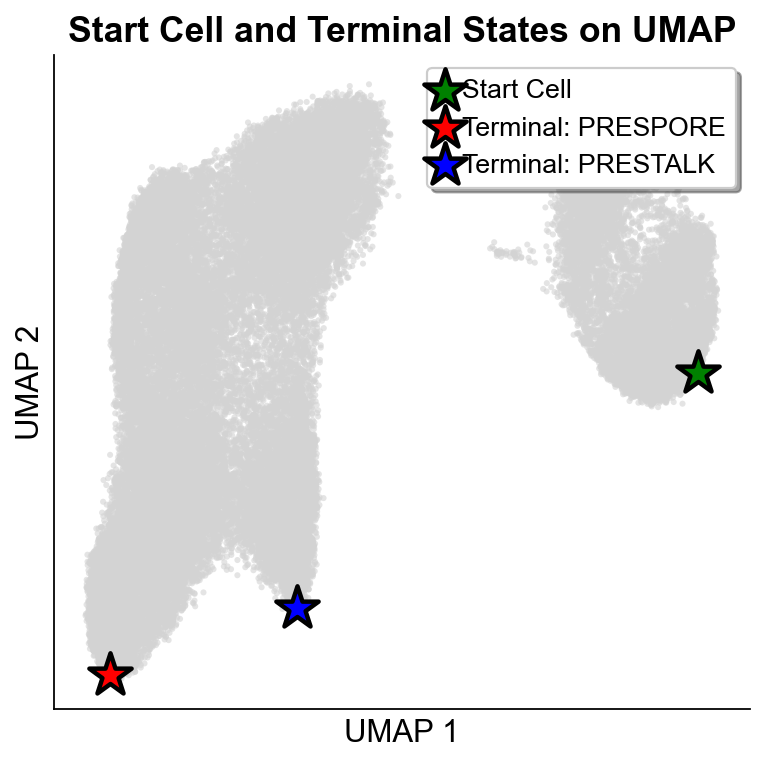

In [175]:
# Create figure
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.embedding(adata, basis="X_uce_umap", 
                size=30, ax=ax, show=False, alpha=0.6)
umap_coords = adata.obsm['X_uce_umap']

# Plot start cell with a star
if start_cell in adata.obs_names:
    start_idx = adata.obs_names.get_loc(start_cell)
    start_coord = umap_coords[start_idx]
    ax.scatter(start_coord[0], start_coord[1], s=400, marker='*', 
               c='green', edgecolors='black', linewidths=2, 
               label='Start Cell', zorder=10)

# Plot terminal states with stars
colors = ['red', 'blue']
for i, (cell_id, cell_type) in enumerate(terminal_states.items()):
    if cell_id in adata.obs_names:
        term_idx = adata.obs_names.get_loc(cell_id)
        term_coord = umap_coords[term_idx]
        ax.scatter(term_coord[0], term_coord[1], s=400, marker='*', 
                   c=colors[i], edgecolors='black', linewidths=2, 
                   label=f'Terminal: {cell_type.upper()}', zorder=10)

# Customize plot
ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.set_title('Start Cell and Terminal States on UMAP', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

## Method 1 - DPT (Diffusion Pseudotime)

**DPT** works like this:
1. **Diffusion map:** Model each cell as a node in a low‑dimensional diffusion space, where edges (short “bridges”) are weighted by transcriptomic similarity—closely related cells share shorter, stronger connections.

2. **Pseudotime calculation:** From a chosen start cell, accumulate diffusion (geodesic) distances along the graph to gauge how far every other cell lies along the developmental manifold.

This gives us a simple timeline of development - early cells have low pseudotime, late cells have high pseudotime.

In [176]:
# Diffusion map
sc.tl.diffmap(adata)

In [177]:
sc.tl.dpt(adata)

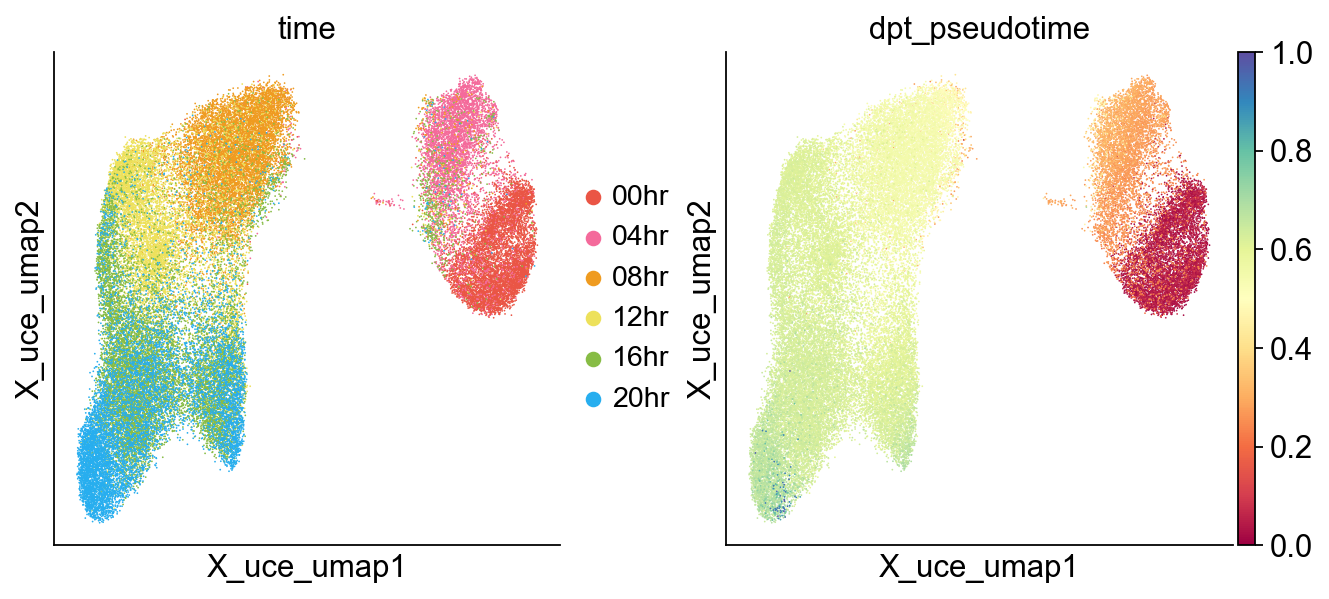

In [178]:
sc.pl.embedding(
    adata,
    basis="X_uce_umap",
    color=["time", "dpt_pseudotime"],
)

## Method 2 - Palantir Analysis

**Palantir** is a more sophisticated method that can handle cells developing into multiple different fates (like our prespore and prestalk cells). 

Palantir works in several steps:
1. **Diffusion maps**: Build a detailed map of cell relationships
2. **Multiscale space**: Look at patterns at different scales of resolution
3. **Trajectory calculation**: Calculate the probability that each cell will become each final cell type

In [179]:
dm_res = palantir.utils.run_diffusion_maps(adata)

In [180]:
ms_data = palantir.utils.determine_multiscale_space(adata)

In [181]:
# imputed_X = palantir.utils.run_magic_imputation(adata)

In [182]:
pr_res = palantir.core.run_palantir(
    adata, 
    start_cell,
    terminal_states=terminal_states,
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.06771524349848429 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.3673614501953125 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [183]:
adata.obsm["X_umap"] = adata.obsm["X_uce_umap"]

### Visualizing Palantir Results

Palantir creates several useful plots:
- **Pseudotime**: How far along development each cell is
- **Branch probabilities**: How likely each cell is to become prespore vs prestalk
- **Entropy**: How "decided" each cell is (low entropy = committed to one fate)

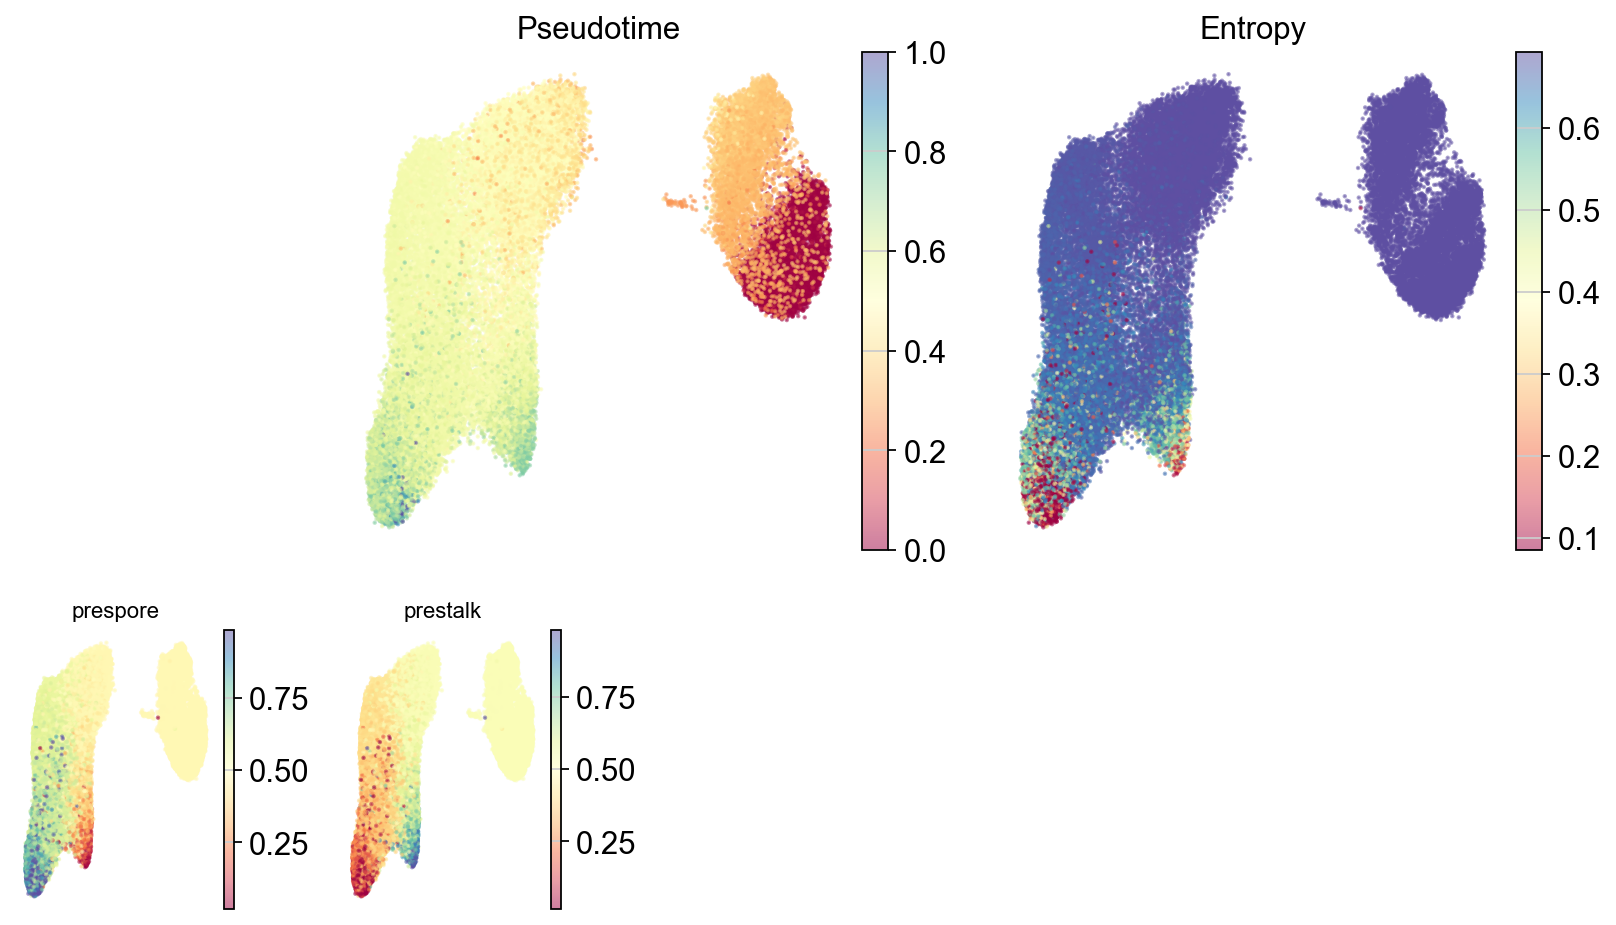

In [184]:
# Plot results
palantir.plot.plot_palantir_results(adata)
plt.show()

We can identify cells that are clearly committed to specific developmental paths.

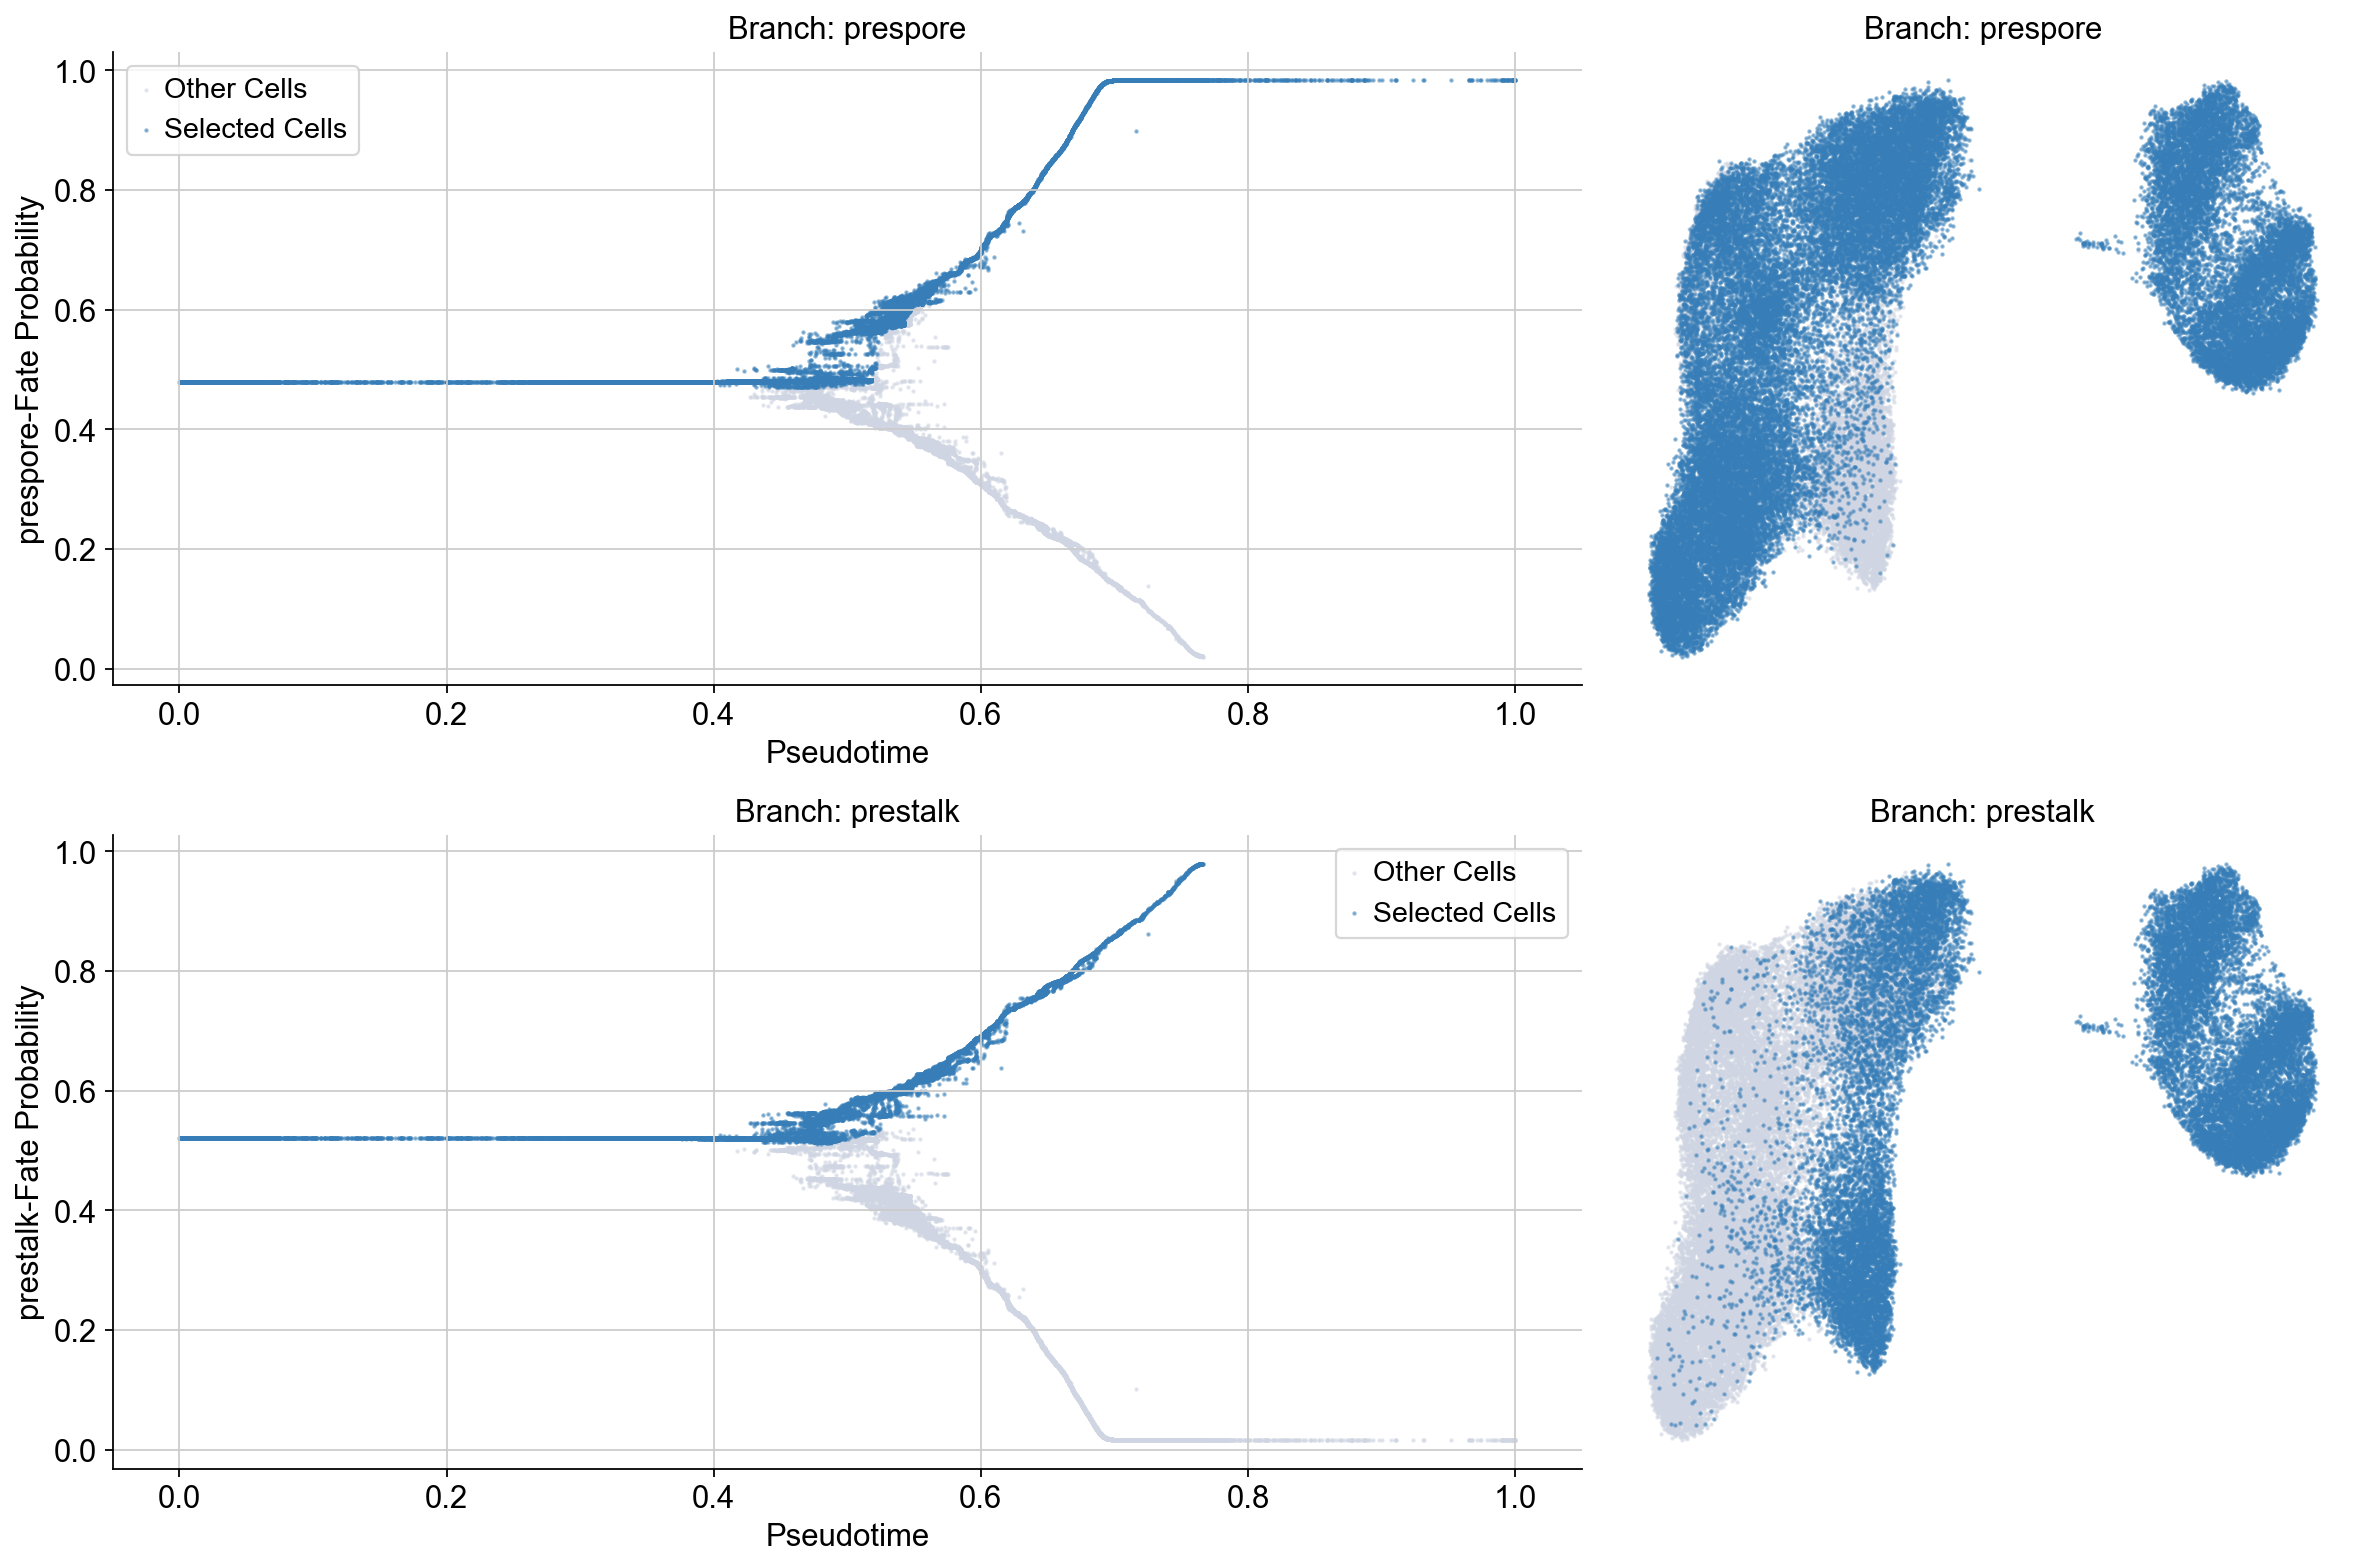

In [185]:
masks = palantir.presults.select_branch_cells(adata, q=0.05, eps=.01)

palantir.plot.plot_branch_selection(adata)
plt.show()

Finally, we can draw arrows showing the predicted developmental paths from our starting cell to the final cell types.

<Axes: title={'center': 'palantir_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

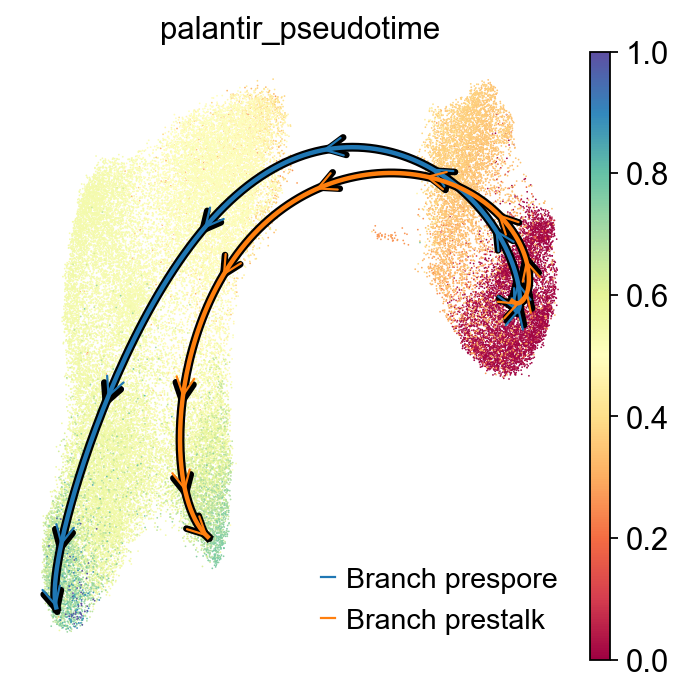

In [186]:
palantir.plot.plot_trajectories(adata, n_arrows=10, pseudotime_interval=(0, 0.7))

## Comparing Both Methods

Now let's compare how well DPT and Palantir agree with each other and with our known information:

1. **Experimental time**: What we actually measured
2. **DPT pseudotime**: What the simpler method predicted
3. **Palantir pseudotime**: What the more sophisticated method predicted

Both methods give similar results.

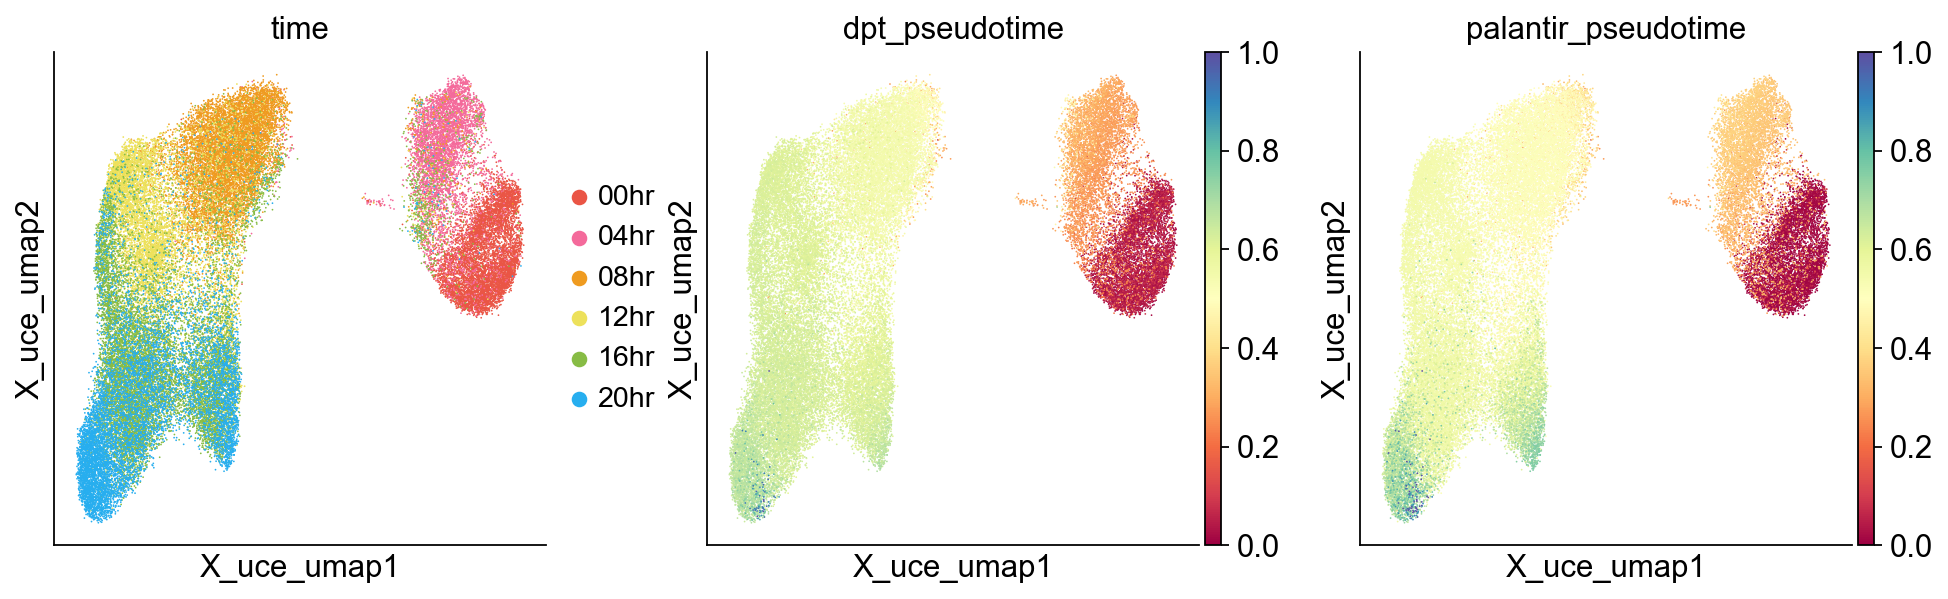

In [187]:
sc.pl.embedding(
    adata,
    basis="X_uce_umap",
    color=["time", "dpt_pseudotime", "palantir_pseudotime"],
)

In [188]:
# Copy the column
adata.obs["cell_type_palantir"] = adata.obs["cell_type"].copy()

# Add 'unassigned' to the categories if not already present
if "non-differentiated" not in adata.obs["cell_type_palantir"].cat.categories:
    adata.obs["cell_type_palantir"] = adata.obs["cell_type_palantir"].cat.add_categories(["non-differentiated"])

# Assign 'unassigned' to missing values
adata.obs.loc[adata.obs["cell_type_palantir"].isna(), "cell_type_palantir"] = "non-differentiated"

## Comparison by Cell Type

Let's create violin plots to see how pseudotime values are distributed within each cell type, using the classification of cell types from the previous analysis.

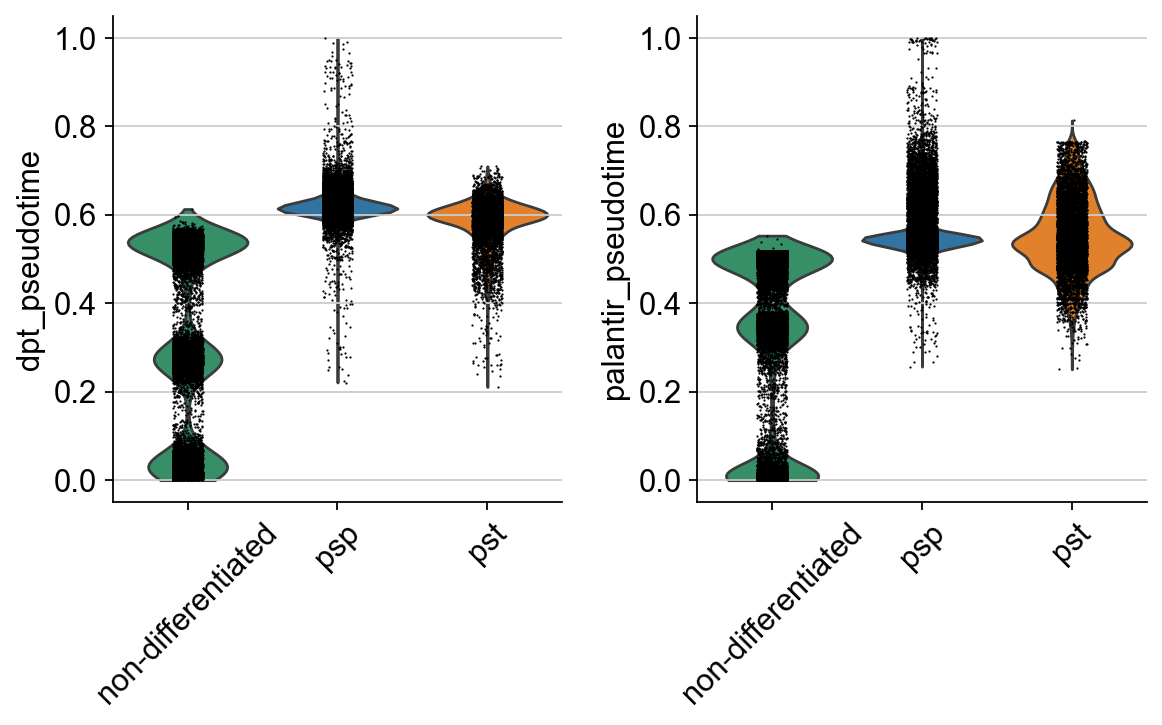

In [189]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="cell_type_palantir",
    rotation=45,
    order=[
        "non-differentiated",
        "psp", 
        "pst",
    ],
)

# Analysis of pseudotime using UCE embeddings
Now, instead of preprocessed counts, let's use the UCE embeddings.

In [190]:
sc.pp.neighbors(adata, use_rep="X_uce")

In [191]:
adata.obsm["X_pca"] = adata.obsm["X_uce"]

In [192]:
# Diffusion map
sc.tl.diffmap(adata)

In [193]:
sc.tl.dpt(adata)

In [194]:
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=6)

In [195]:
ms_data = palantir.utils.determine_multiscale_space(adata)

In [196]:
pr_res = palantir.core.run_palantir(
    adata, 
    start_cell,
    terminal_states=terminal_states,
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.08667874733606974 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.4221353809038798 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


### Visualizing Palantir Results

Palantir creates several useful plots:
- **Pseudotime**: How far along development each cell is
- **Branch probabilities**: How likely each cell is to become prespore vs prestalk
- **Entropy**: How "decided" each cell is (low entropy = committed to one fate)

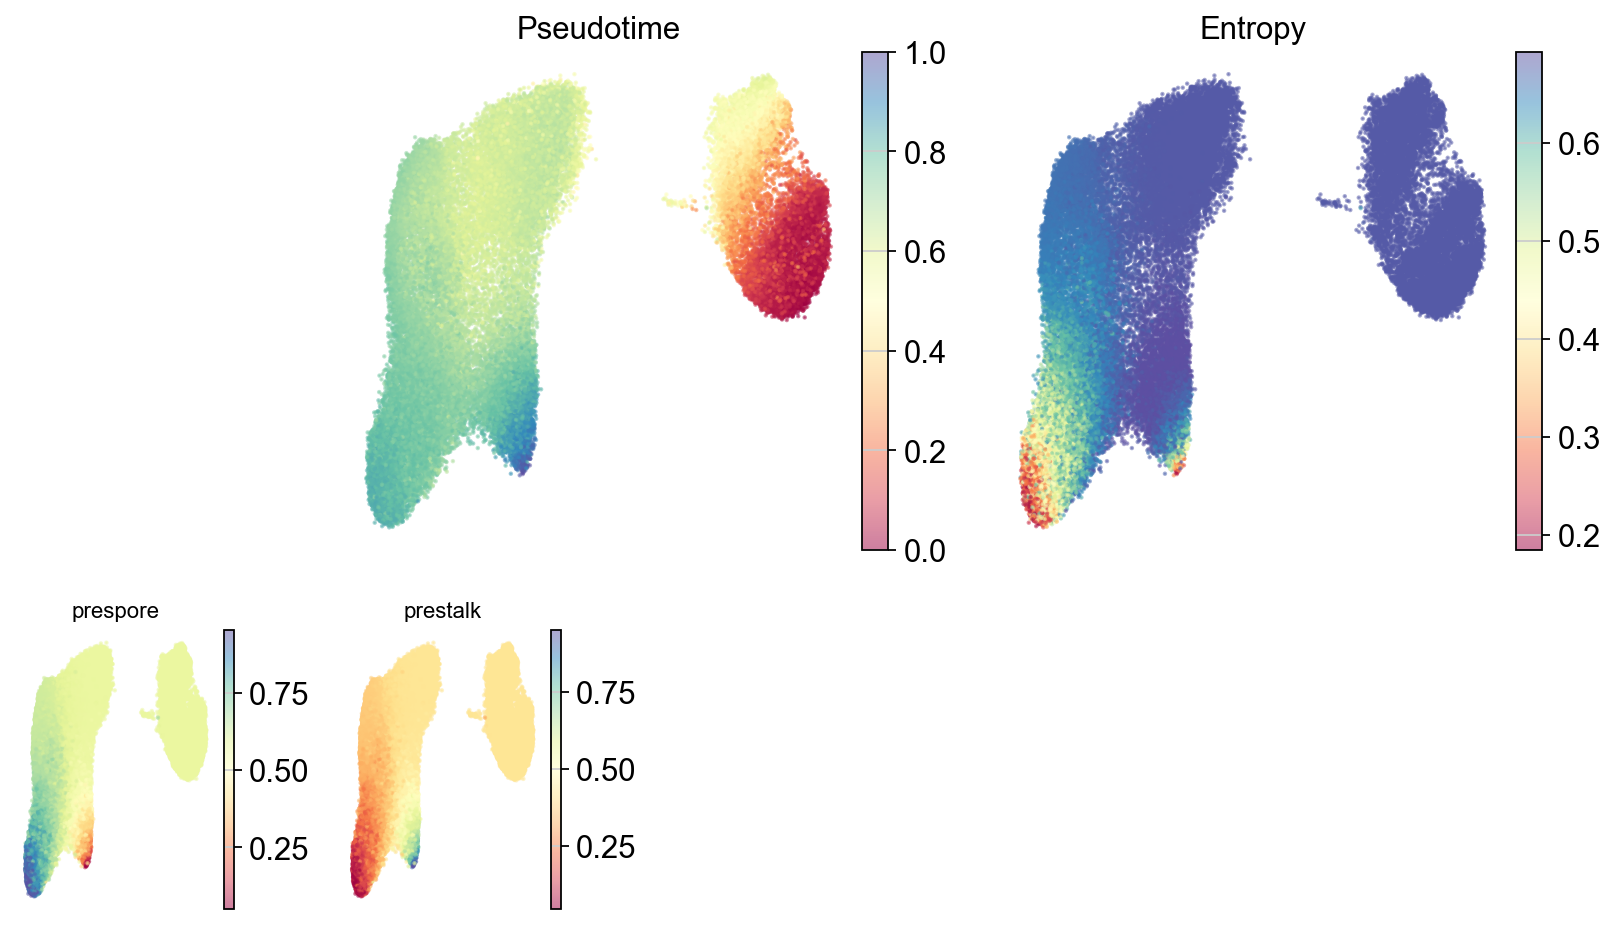

In [197]:
# Plot results
palantir.plot.plot_palantir_results(adata)
plt.show()

We can identify cells that are clearly committed to specific developmental paths.

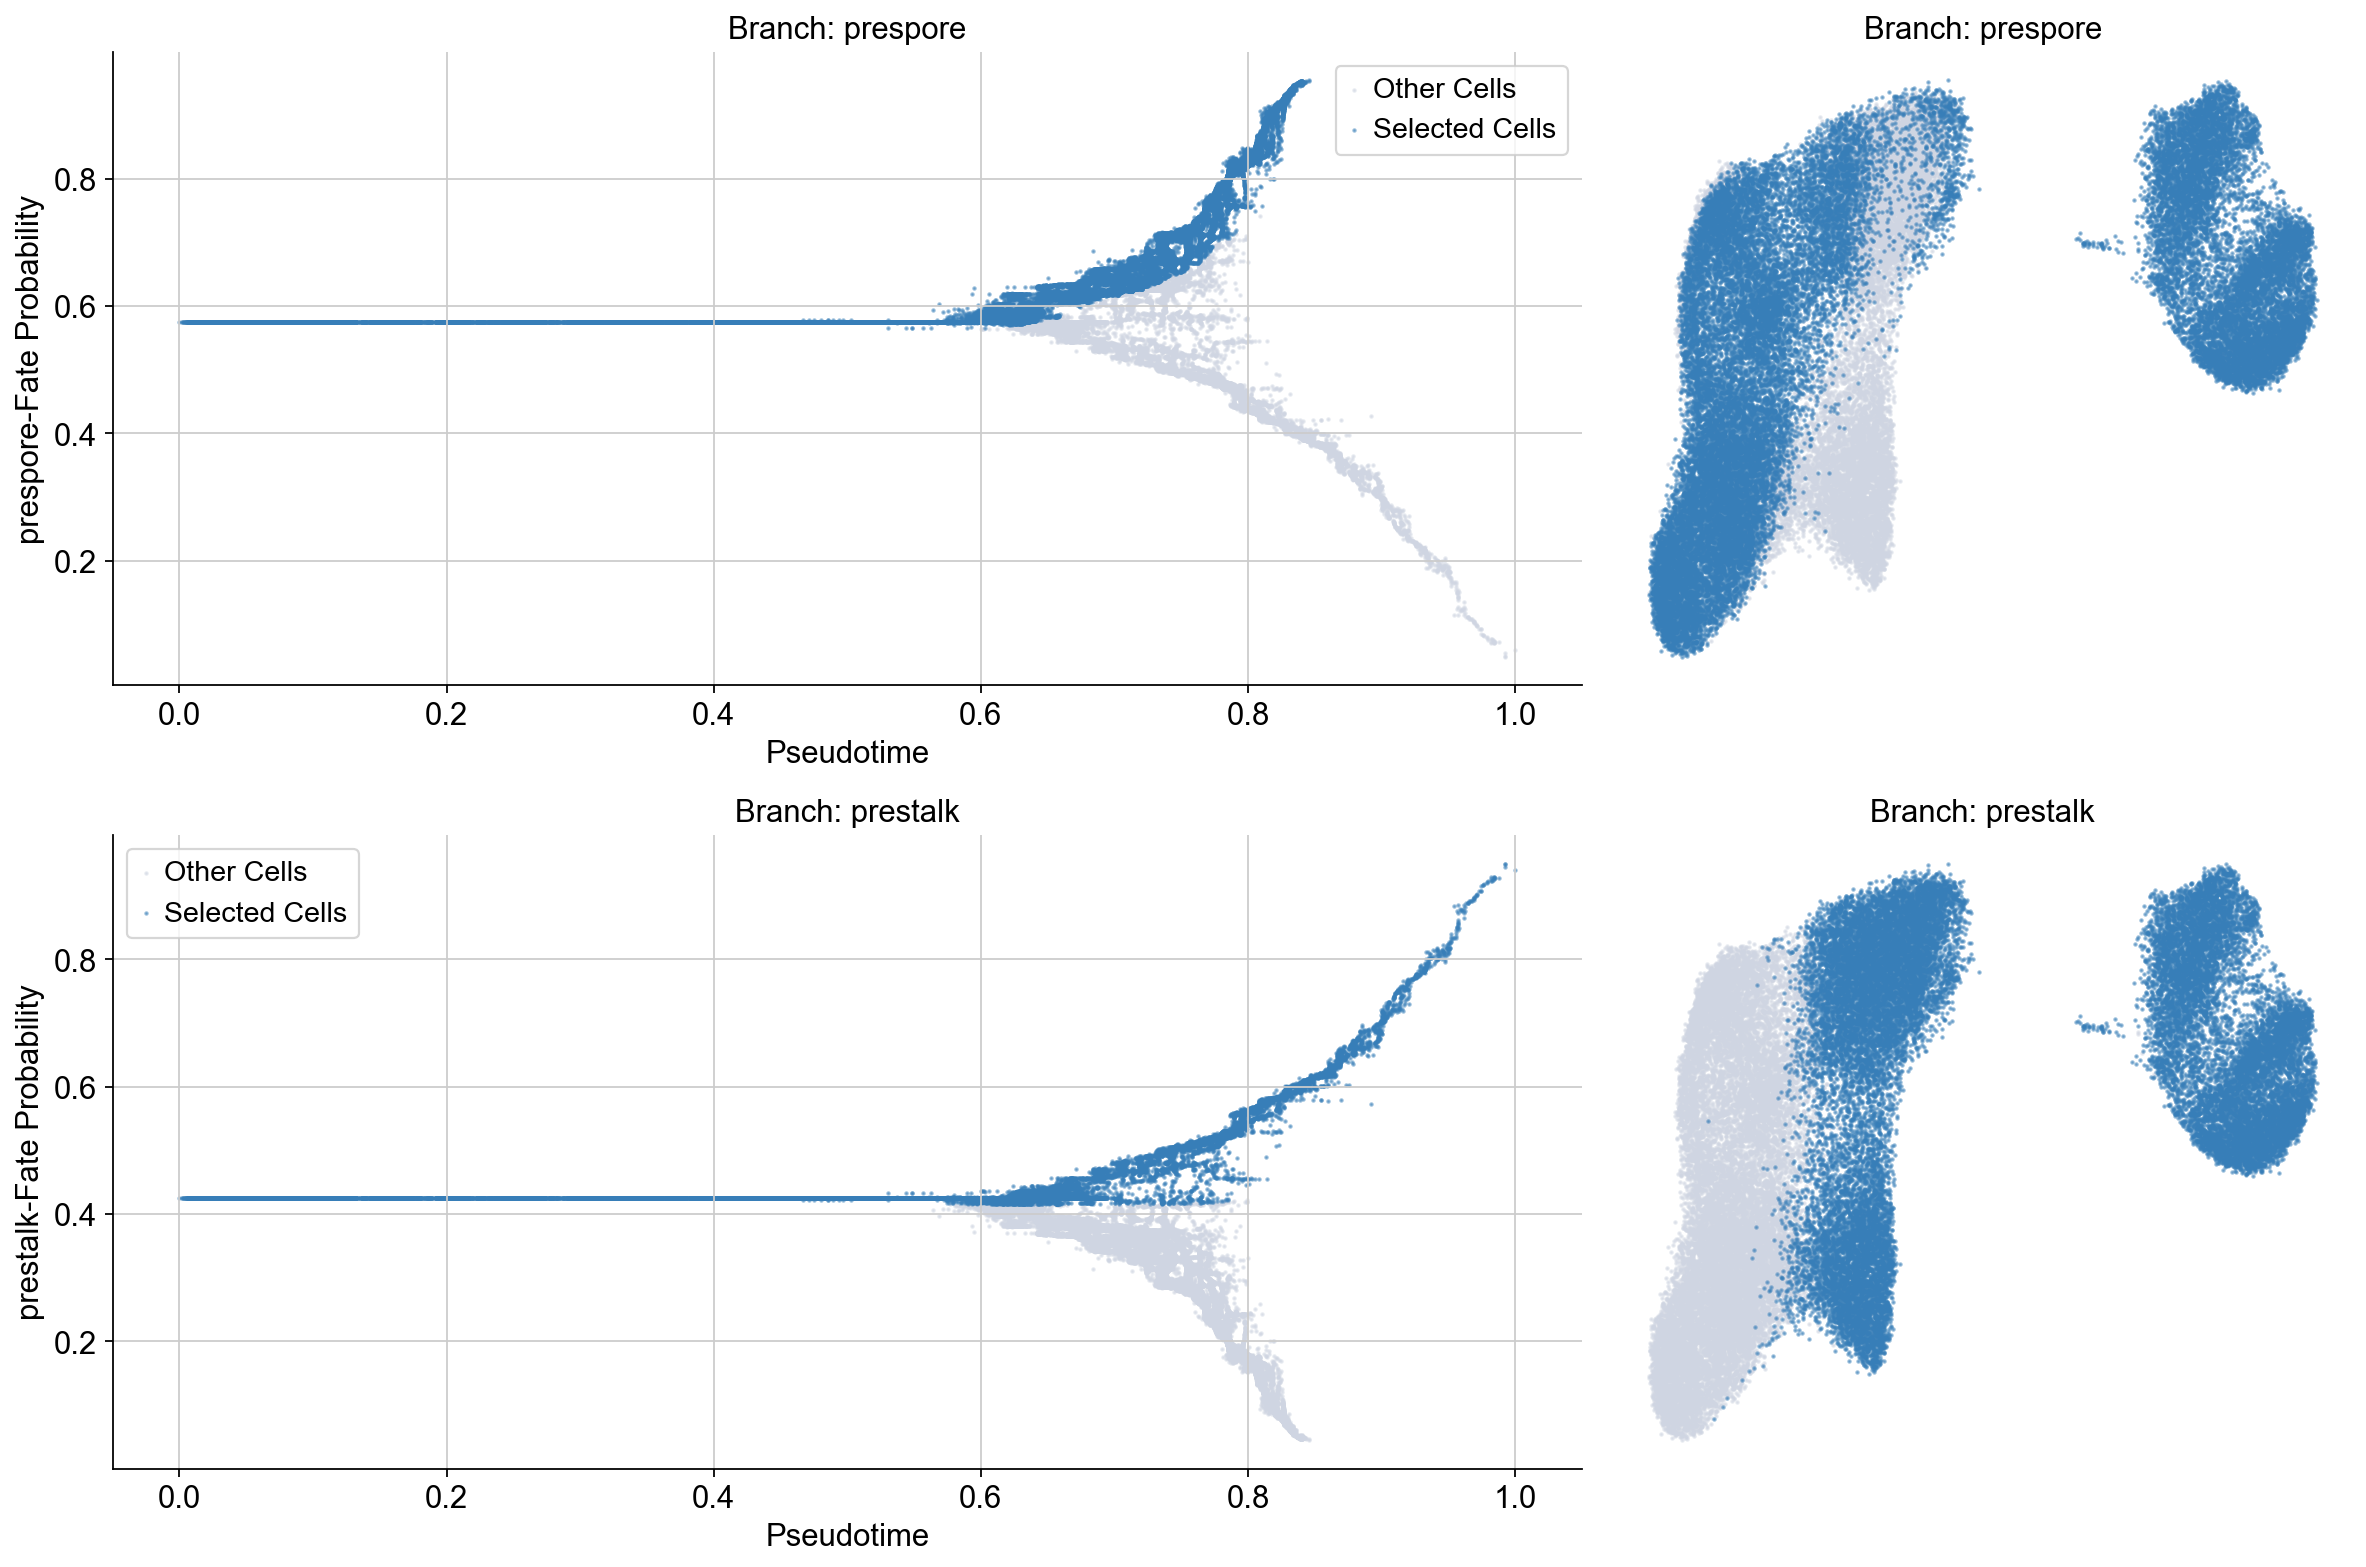

In [198]:
masks = palantir.presults.select_branch_cells(adata, q=0.07, eps=.01)

palantir.plot.plot_branch_selection(adata)
plt.show()

Finally, we can draw arrows showing the predicted developmental paths from our starting cell to the final cell types.

<Axes: title={'center': 'palantir_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

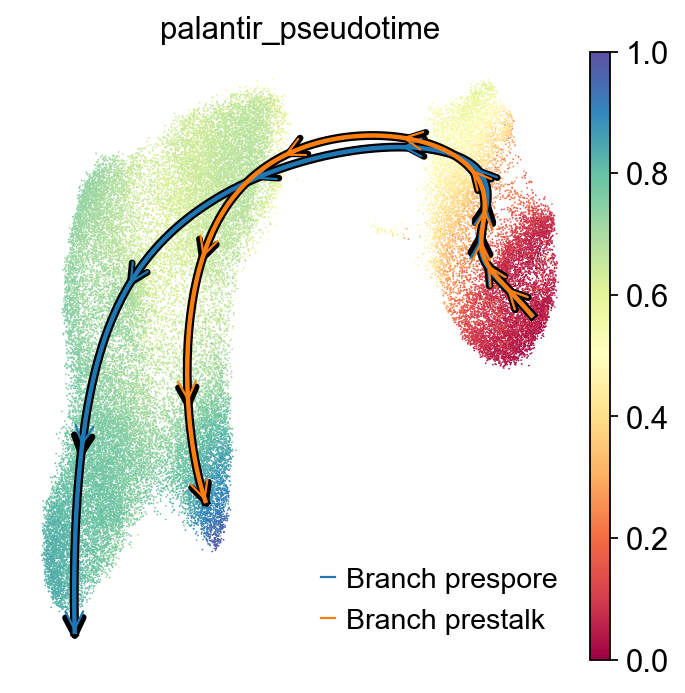

In [199]:
palantir.plot.plot_trajectories(adata, n_arrows=10, pseudotime_interval=(0, 0.85))

## Comparing Both Methods

Now let's compare how well DPT and Palantir agree with each other and with our known information:

1. **Experimental time**: What we actually measured
2. **DPT pseudotime**: What the simpler method predicted
3. **Palantir pseudotime**: What the more sophisticated method predicted

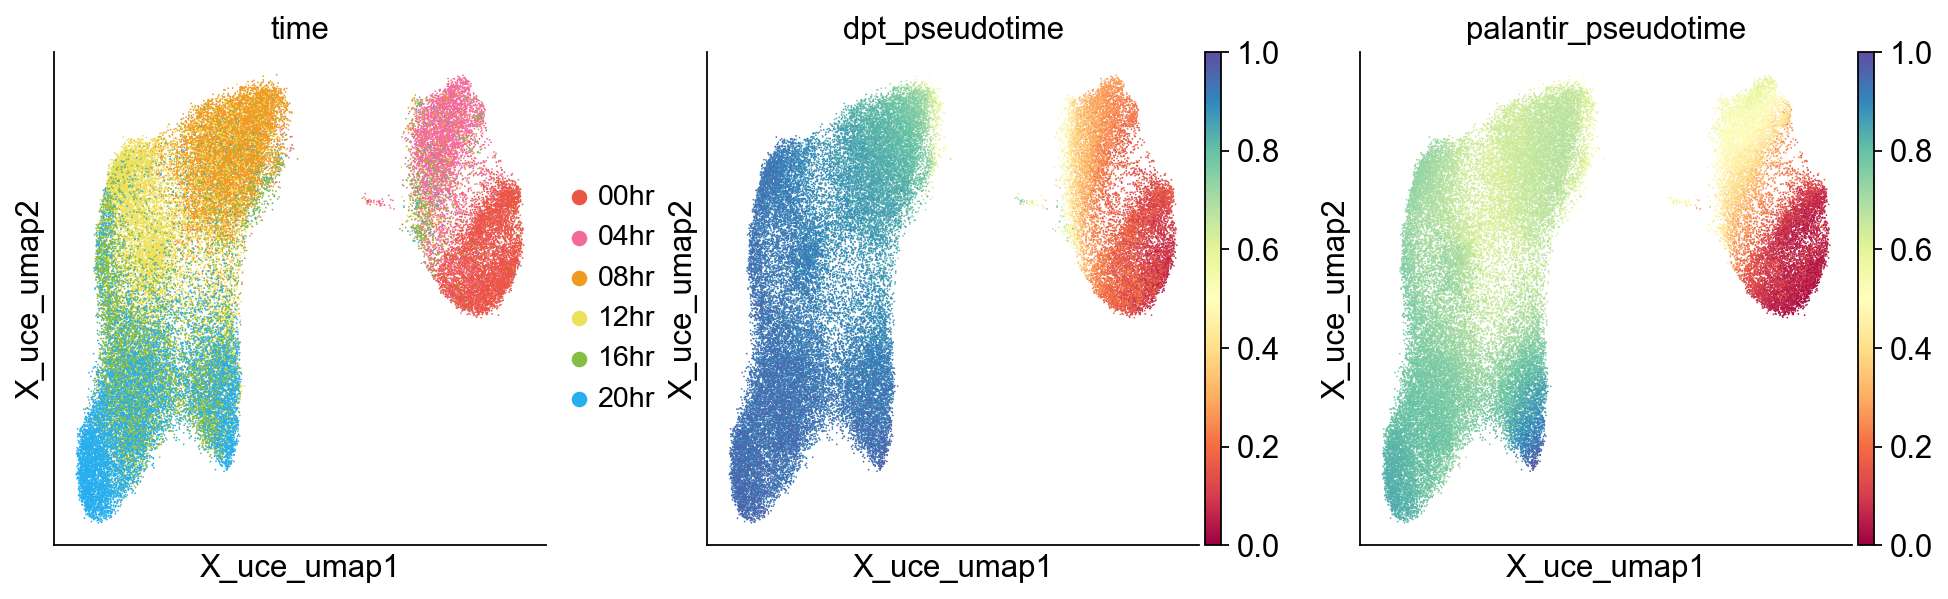

In [201]:
sc.pl.embedding(
    adata,
    basis="X_uce_umap",
    color=["time", "dpt_pseudotime", "palantir_pseudotime"],
)

## Comparison by Cell Type

Let's create violin plots to see how pseudotime values are distributed within each cell type, using the classification of cell types from the previous analysis.

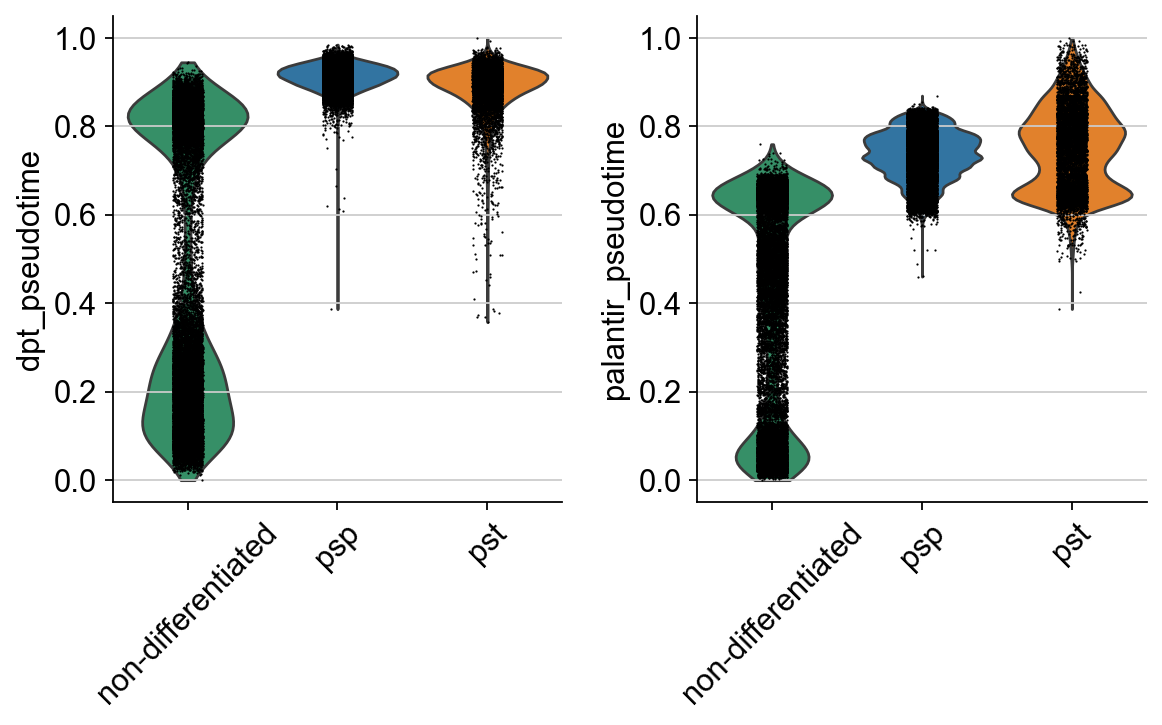

In [202]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="cell_type_palantir",
    rotation=45,
    order=[
        "non-differentiated",
        "psp", 
        "pst",
    ],
)

In [206]:
!jupyter nbconvert --to html --TemplateExporter.exclude_input=True 04_pseudotime_analysis.ipynb --output-dir=../../scrna_trajectory --output=index.html > /dev/null 2>&1